<a href="https://colab.research.google.com/github/jk-math/Image-Recognition/blob/main/Cats_v_Dogs_ImageAug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import urllib.request
import zipfile
import random
import shutil
from shutil import copyfile
import os
from PIL import Image
import warnings
import matplotlib.pyplot as plt
from google.colab import files
from keras.preprocessing import image
import matplotlib.image as mpimg
import itertools

Download the Cats v Dogs dataset from https://www.microsoft.com/en-us/download/details.aspx?id=54765

The download is a zip folder containing all of the image files. We will make directories to store the extracted images

In [2]:
path = '/content/drive/MyDrive/Colab Notebooks/Cats-v-Dogs-Classifier/kagglecatsanddogs.zip'
z = zipfile.ZipFile(path, 'r')
z.extractall('/tmp')
z.close()

The images are in a folder titled Pet Images and there are subdirectories for Cat and Dog. We need to create training and validation sets from the entire dataset.

In [3]:
os.listdir('/tmp/PetImages')

['Dog', 'Cat']

In [4]:
base_dir = '/tmp/PetImages'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

dog_dir = os.path.join(base_dir, 'Dog')
cat_dir = os.path.join(base_dir, 'Cat')

# Directory with our training cat pictures
train_dir_cats = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dir_dogs = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_dir_cats = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dir_dogs = os.path.join(validation_dir, 'dogs')

I think the dataset provided by Kaggle is cleaned and some corrupt images from the original dataset are removed. However, possibly as a result of unzipping the file, there are some corrupt files in the dataset. So, we write a function that identifies corrupt files and removes them. 

In [5]:
def is_corrupt(path):
  try:
    img = Image.open(path)
    img.verify()
  except:
    return True
  return False

In [6]:
def remove_corrupt(dir):
  warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)
  file_list = os.listdir(dir)
  n_files = len(file_list)
  print('--- Processing {} files ---'.format(n_files))
  n_zero_size = 0
  n_corrupt = 0
  for filename in file_list:
    path = os.path.join(dir, filename)
    if os.path.getsize(path) == 0:
      n_zero_size += 1
      os.remove(path)
      # delete corrupt
    elif is_corrupt(path):
      n_corrupt += 1
      os.remove(path)
      # delete corrupt
  n_removed = n_zero_size + n_corrupt
  print('--- {} corrupt files removed ---'.format(n_removed))

In [7]:
remove_corrupt(cat_dir)
remove_corrupt(dog_dir)

--- Processing 12501 files ---
--- 2 corrupt files removed ---
--- Processing 12501 files ---
--- 2 corrupt files removed ---


Create directories so we can use flow_from_directory to augment images in memory

In [8]:
for dir in [train_dir_cats, train_dir_dogs, validation_dir_cats, validation_dir_dogs]:
  try:
    os.makedirs(dir)
  except OSError as error: 
    print(error)

In [9]:
print(len(os.listdir('/tmp/PetImages/Dog')))
print(len(os.listdir('/tmp/PetImages/Cat')))

12499
12499


In [10]:
os.listdir(base_dir)

['Dog', 'train', 'validation', 'Cat']

Write a function to create training and validation directory for use with flow from directory while training

In [11]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = os.listdir(SOURCE)
    num_files = len(files)
    files = random.sample(files, num_files)
    train_split = round(SPLIT_SIZE* num_files)
    i = 0
    for file in files[:train_split]:
        p = os.path.join(SOURCE, file)
        if os.path.getsize(p)==0:
            continue
        else:
            copyfile(p,os.path.join(TRAINING,file))
            i += 1
    print('{} files loaded from {} and copied to {}'.format(i, SOURCE, TRAINING))
    j = 0
    for file in files[train_split:]:
        p = os.path.join(SOURCE, file)
        if os.path.getsize(p)==0:
            continue
        else:
            copyfile(p,os.path.join(TESTING,file))
            j += 1
    print('{} files loaded from {} and copied to {}'.format(j, SOURCE, TESTING))

In [12]:
split_data(dog_dir, train_dir_dogs, validation_dir_dogs, 0.9)
split_data(cat_dir, train_dir_cats, validation_dir_cats, 0.9)

11249 files loaded from /tmp/PetImages/Dog and copied to /tmp/PetImages/train/dogs
1250 files loaded from /tmp/PetImages/Dog and copied to /tmp/PetImages/validation/dogs
11249 files loaded from /tmp/PetImages/Cat and copied to /tmp/PetImages/train/cats
1250 files loaded from /tmp/PetImages/Cat and copied to /tmp/PetImages/validation/cats


In [13]:
def plot_training_images(base_dir):
# plot some random training images
  img_file_paths = os.listdir(base_dir)
  fig, axs = plt.subplots(2,4)
  fig.set_figwidth(12)
  fig.set_figheight(6)
  for i in range(2):
    for j in range(4):
      path = os.path.join(base_dir, random.choice(img_file_paths))
      img = mpimg.imread(path)
      axs[i,j].imshow(img)
      axs[i,j].axis('off')

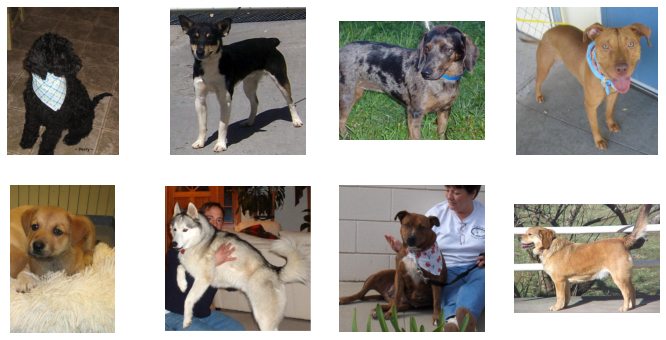

In [14]:
plot_training_images('/tmp/PetImages/train/dogs')

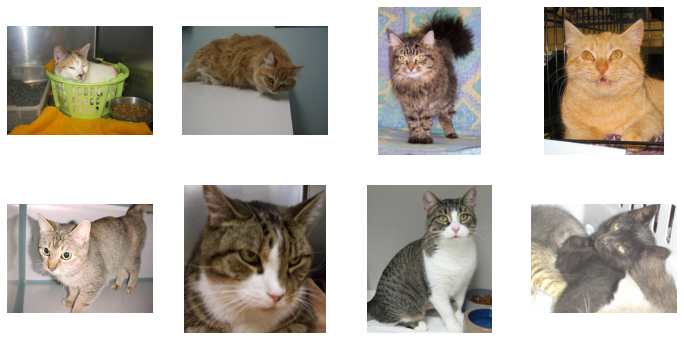

In [15]:
plot_training_images('/tmp/PetImages/train/cats')

Use ImageDataGenerator and flow_from_directory to setup image augmentation pipeline for training

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 45,
                                   width_shift_range=0.25,
                                  height_shift_range=0.25,
                                  shear_range=0.2,
                                  zoom_range=0.25,
                                  fill_mode="nearest",
                                   horizontal_flip = True)

train_gen = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150, 150),  
        batch_size=32,
        class_mode='binary')

valid_datagen = ImageDataGenerator(rescale = 1./255)

valid_gen = valid_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 32,
    class_mode = 'binary')

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


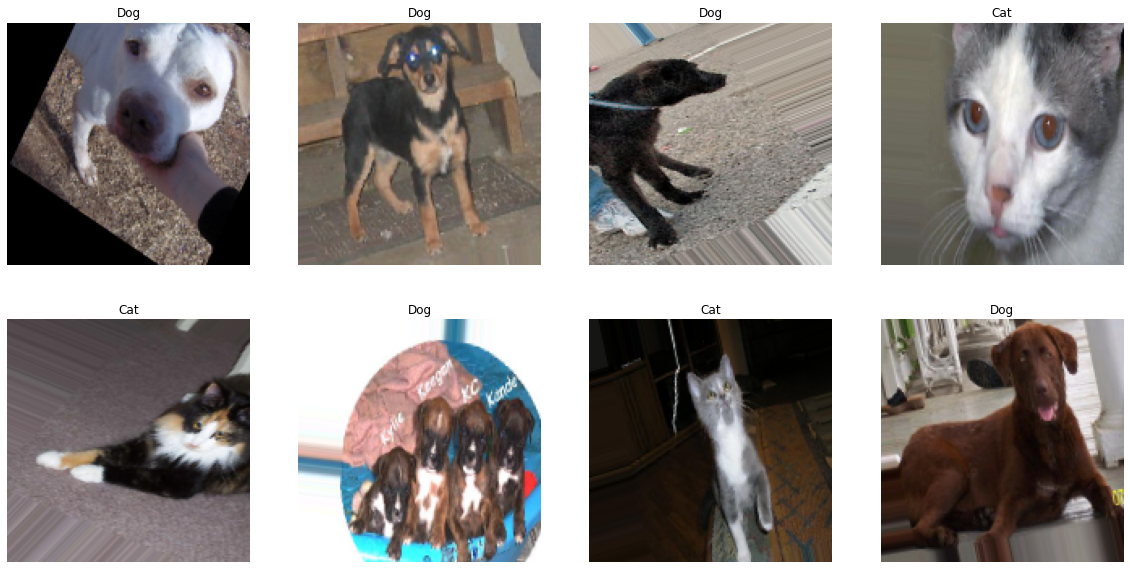

In [18]:
# execute cell to print 8 random images that have been passed through the ImageDataGenerator
for batch in train_gen:
  images = batch[0][:8]
  labels = batch[1][:8]
  fig, axs = plt.subplots(2,4)
  fig.set_figwidth(20)
  fig.set_figheight(10)
  for (k, (i,j)) in enumerate(itertools.product(list(range(2)),list(range(4)))):
    axs[i,j].imshow(images[k])
    axs[i,j].axis('off')
    if int(labels[k]) == 0:
      axs[i,j].set_title('Cat')
    else:
      axs[i,j].set_title('Dog')
  break

In [19]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [20]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                          restore_best_weights = True, patience = 10)

check_point = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/Colab Notebooks/Cats-v-Dogs-Classifier/CNN_Checkpoint', 
          monitor = 'val_accuracy', save_weights_only = False, save_freq = 'epoch',
          save_best_only = True, verbose = 1)

cnn_history = cnn_model.fit(train_gen, epochs = 500, validation_data = valid_gen,
                    callbacks = [early_stop, check_point])

Epoch 1/500
704/704 [==============================] - 204s 243ms/step - loss: 0.6966 - accuracy: 0.5186 - val_loss: 0.6831 - val_accuracy: 0.5596

Epoch 00001: val_accuracy improved from -inf to 0.55960, saving model to /content/drive/MyDrive/Colab Notebooks/Cats-v-Dogs-Classifier/CNN_Checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Cats-v-Dogs-Classifier/CNN_Checkpoint/assets
Epoch 2/500
704/704 [==============================] - 171s 242ms/step - loss: 0.6719 - accuracy: 0.5852 - val_loss: 0.6289 - val_accuracy: 0.6400

Epoch 00002: val_accuracy improved from 0.55960 to 0.64000, saving model to /content/drive/MyDrive/Colab Notebooks/Cats-v-Dogs-Classifier/CNN_Checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Cats-v-Dogs-Classifier/CNN_Checkpoint/assets
Epoch 3/500
704/704 [==============================] - 170s 242ms/step - loss: 0.6324 - accuracy: 0.6441 - val_loss: 0.6037 - val_accuracy: 0.6796

Epoch 00003: va

In [21]:
def plot_training_metrics(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  epochs_range = range(len(loss))

  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Acc')
  plt.plot(epochs_range, val_acc, label='Validation Acc')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Acc')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
  plt.close()

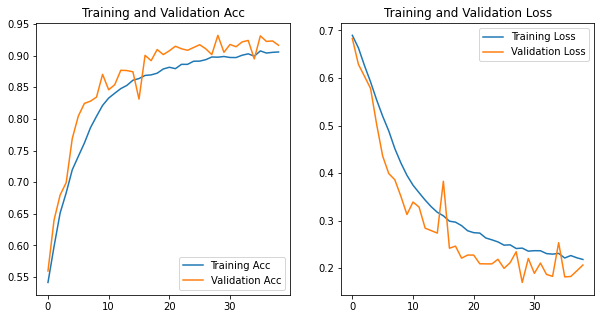

In [22]:
plot_training_metrics(cnn_history)

In [24]:
def predict_on_image(model, target_size): # will prompt for you to upload image files

  uploaded = files.upload()

  for f_name in uploaded.keys():
    path = '/content/' + f_name
    full_img = mpimg.imread(path)
    plt.imshow(full_img) # displays original image
    plt.axis('Off')
    plt.show()
    img = image.load_img(path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    prob = model.predict(x)

    p = prob[0][0].astype('float')

    if p > 0.5:
      print('The model predicts that the image file {} is a dog with probability {}'.format(f_name, round(p, 4)))
    else:
      print('The model predicts that the image file {} is a cat with probability {}'.format(f_name, round(1-p, 4)))

Saving hard_to_classify_dog.jpg to hard_to_classify_dog.jpg


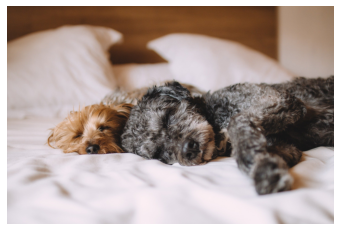

The model predicts that the image file hard_to_classify_dog.jpg is a dog with probability 1.0


In [25]:
predict_on_image(cnn_model, target_size = (150,150))

In [26]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 45,
                                   width_shift_range=0.25,
                                  height_shift_range=0.25,
                                  shear_range=0.2,
                                  zoom_range=0.25,
                                  fill_mode="nearest",
                                   horizontal_flip = True)

train_gen = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(128, 128),  # change target size for use with pretrained model
        batch_size=32,
        class_mode='binary')

valid_datagen = ImageDataGenerator(rescale = 1./255)

valid_gen = valid_datagen.flow_from_directory(
    validation_dir,
    target_size = (128, 128),
    batch_size = 32,
    class_mode = 'binary')

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [27]:
import tensorflow_hub as hub

In [28]:
transfer_model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v1_100_128/feature_vector/4", trainable=False),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

transfer_model.compile(loss='binary_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                          restore_best_weights = True, patience = 10)

check_point = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/Colab Notebooks/Cats-v-Dogs-Classifier/Transfer_Checkpoint', 
          monitor = 'val_accuracy', save_weights_only = False, save_freq = 'epoch',
          save_best_only = True, verbose = 1)

transfer_history = transfer_model.fit(train_gen, epochs = 500, validation_data = valid_gen,
                    callbacks = [early_stop, check_point])

Epoch 1/500
704/704 [==============================] - 140s 196ms/step - loss: 0.2777 - accuracy: 0.8915 - val_loss: 0.0936 - val_accuracy: 0.9612

Epoch 00001: val_accuracy improved from -inf to 0.96120, saving model to /content/drive/MyDrive/Colab Notebooks/Cats-v-Dogs-Classifier/Transfer_Checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Cats-v-Dogs-Classifier/Transfer_Checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Cats-v-Dogs-Classifier/Transfer_Checkpoint/assets


Epoch 2/500
704/704 [==============================] - 138s 196ms/step - loss: 0.1505 - accuracy: 0.9386 - val_loss: 0.0808 - val_accuracy: 0.9644

Epoch 00002: val_accuracy improved from 0.96120 to 0.96440, saving model to /content/drive/MyDrive/Colab Notebooks/Cats-v-Dogs-Classifier/Transfer_Checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Cats-v-Dogs-Classifier/Transfer_Checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Cats-v-Dogs-Classifier/Transfer_Checkpoint/assets


Epoch 3/500
704/704 [==============================] - 138s 196ms/step - loss: 0.1492 - accuracy: 0.9382 - val_loss: 0.0959 - val_accuracy: 0.9612

Epoch 00003: val_accuracy did not improve from 0.96440
Epoch 4/500
704/704 [==============================] - 138s 195ms/step - loss: 0.1328 - accuracy: 0.9466 - val_loss: 0.0825 - val_accuracy: 0.9656

Epoch 00004: val_accuracy improved from 0.96440 to 0.96560, saving model to /content/drive/MyDrive/Colab Notebooks/Cats-v-Dogs-Classifier/Transfer_Checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Cats-v-Dogs-Classifier/Transfer_Checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Cats-v-Dogs-Classifier/Transfer_Checkpoint/assets


Epoch 5/500
704/704 [==============================] - 138s 196ms/step - loss: 0.1310 - accuracy: 0.9485 - val_loss: 0.0645 - val_accuracy: 0.9724

Epoch 00005: val_accuracy improved from 0.96560 to 0.97240, saving model to /content/drive/MyDrive/Colab Notebooks/Cats-v-Dogs-Classifier/Transfer_Checkpoint
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Cats-v-Dogs-Classifier/Transfer_Checkpoint/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Cats-v-Dogs-Classifier/Transfer_Checkpoint/assets


Epoch 6/500
704/704 [==============================] - 138s 196ms/step - loss: 0.1229 - accuracy: 0.9499 - val_loss: 0.0738 - val_accuracy: 0.9680

Epoch 00006: val_accuracy did not improve from 0.97240
Epoch 7/500
704/704 [==============================] - 138s 196ms/step - loss: 0.1259 - accuracy: 0.9500 - val_loss: 0.0805 - val_accuracy: 0.9660

Epoch 00007: val_accuracy did not improve from 0.97240
Epoch 8/500
704/704 [==============================] - 137s 195ms/step - loss: 0.1256 - accuracy: 0.9524 - val_loss: 0.0625 - val_accuracy: 0.9724

Epoch 00008: val_accuracy did not improve from 0.97240
Epoch 9/500
704/704 [==============================] - 137s 195ms/step - loss: 0.1218 - accuracy: 0.9515 - val_loss: 0.0772 - val_accuracy: 0.9700

Epoch 00009: val_accuracy did not improve from 0.97240
Epoch 10/500
704/704 [==============================] - 138s 195ms/step - loss: 0.1193 - accuracy: 0.9522 - val_loss: 0.1276 - val_accuracy: 0.9576

Epoch 00010: val_accuracy did not impro

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Cats-v-Dogs-Classifier/Transfer_Checkpoint/assets


Epoch 12/500
704/704 [==============================] - 138s 196ms/step - loss: 0.1224 - accuracy: 0.9512 - val_loss: 0.1099 - val_accuracy: 0.9612

Epoch 00012: val_accuracy did not improve from 0.97440
Epoch 13/500
704/704 [==============================] - 139s 197ms/step - loss: 0.1147 - accuracy: 0.9527 - val_loss: 0.0719 - val_accuracy: 0.9720

Epoch 00013: val_accuracy did not improve from 0.97440
Epoch 14/500
704/704 [==============================] - 138s 196ms/step - loss: 0.1163 - accuracy: 0.9545 - val_loss: 0.0789 - val_accuracy: 0.9716

Epoch 00014: val_accuracy did not improve from 0.97440
Epoch 15/500
704/704 [==============================] - 138s 196ms/step - loss: 0.1067 - accuracy: 0.9587 - val_loss: 0.0870 - val_accuracy: 0.9652

Epoch 00015: val_accuracy did not improve from 0.97440
Epoch 16/500
704/704 [==============================] - 138s 196ms/step - loss: 0.1135 - accuracy: 0.9552 - val_loss: 0.0776 - val_accuracy: 0.9708

Epoch 00016: val_accuracy did not i

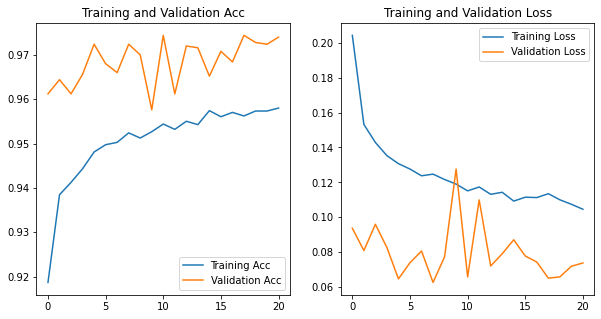

In [29]:
plot_training_metrics(transfer_history)

Saving hard_to_classify_dog.jpg to hard_to_classify_dog (1).jpg


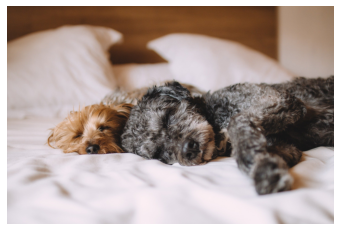

The model predicts that the image file hard_to_classify_dog.jpg is a cat with probability 0.6713


In [30]:
predict_on_image(transfer_model, target_size = (128,128))